In [1]:
%load_ext autoreload
%autoreload 2

In [428]:
from scipy.optimize import dual_annealing
from classical_optimization.qaoa_circuits import execute_qaoa_circuit_and_estimate_cost
import numpy as np
from qiskit import Aer, execute
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model
import networkx as nx

np.random.seed(666)
reprate = 50 
one_hour = 60 * 60 #seconds
max_gamma = 2 * np.pi
max_beta = np.pi
simulator = Aer.get_backend('qasm_simulator')
noise_model = create_noise_model(cz_fidelity=1)

shots_per_point = 50
reg = 3
n = 5
seed = 666
graph = nx.watts_strogatz_graph(n, reg, .5, seed=seed)
terms = {(i, j): np.random.rand() for i, j in graph.edges}
circ_ex = None

def weights(graph):
    rtn = {}
    for e in graph.edges:
        weight = graph.get_edge_data(e[0], e[1])['weight']
        rtn[e] = weight
    return rtn

def objective(graph):
    #Hack for backwards compatibility.
    num_rows = len(graph.nodes)
    num_cols = 1

    history = []
    def store_log(func):
        def logged_func(x):
            ret = func(x)
            history.append((x, ret))
            return ret
        return logged_func

    @store_log
    def gamma_beta_objective(gamma_beta):
        return np.sum(np.abs(gamma_beta)) + np.random.normal(scale=100)
    return gamma_beta_objective, history



In [429]:
import networkx as nx
obj, hist = objective(graph)
all_data = []
bound = np.pi*10
samples = 10
for g in np.linspace(-bound, bound, num=samples):
    data = []
    print(g)
    for b in np.linspace(-bound, bound, num=samples):
        data.append(obj([b, g]))
    all_data.append(data)

-31.41592653589793
-24.434609527920614
-17.453292519943297
-10.471975511965976
-3.4906585039886586
3.490658503988662
10.47197551196598
17.453292519943297
24.434609527920614
31.41592653589793


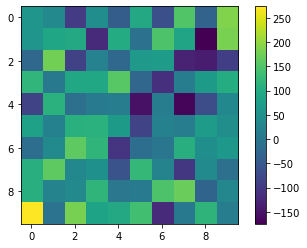

In [430]:
import matplotlib.pyplot as plt
plt.imshow(np.array(all_data))
plt.colorbar()

In [431]:
from es import SimpleGA, CMAES, PEPG, OpenES
NPARAMS = 2
NPOPULATION = 10
oes = OpenES(NPARAMS,                  # number of model parameters
            sigma_init=0.025*np.pi*5,            # initial standard deviation
            sigma_decay=1,         # don't anneal standard deviation
            learning_rate=0.005,         # learning rate for standard deviation
            learning_rate_decay = 0.0, # annealing the learning rate
            popsize=NPOPULATION,       # population size
            antithetic=False,          # whether to use antithetic sampling
            weight_decay=0.00,         # weight decay coefficient
            rank_fitness=False,        # use rank rather than fitness numbers
            forget_best=True)

In [432]:
from tqdm import tqdm
MAX_ITERATION = 100
fit_func1, history = objective(graph)
fit_func = lambda x: fit_func1(x)
# defines a function to use solver to solve fit_func
def test_solver(solver):
    history = []
    for j in tqdm(range(MAX_ITERATION)):
        solutions = solver.ask()
        fitness_list = np.zeros(solver.popsize)
        for i in range(solver.popsize):
            fitness_list[i] = fit_func(solutions[i])
        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        print(result)
        history.append((result))
        if (j+1) % 100 == 0:
            print("fitness at iteration", (j+1), result[1])
    print("local optimum discovered by solver:\n", result[0])
    print("fitness score at this local optimum:", result[1])
    return history, result

In [433]:
fit_func1, history = objective(graph)
fit_func1((np.array([.25  , .5])))

137.6510169823279

In [434]:
history, result = test_solver(oes)


100%|██████████| 100/100 [00:00<00:00, 2317.74it/s]

(array([-0.55883229, -0.38982509]), 145.4953097300882, 145.4953097300882, 0.39269908169872414)
(array([-0.28129507, -0.41448123]), 126.6833122354089, 126.6833122354089, 0.39269908169872414)
(array([ 0.57971176, -0.13021802]), 89.35657089678358, 89.35657089678358, 0.39269908169872414)
(array([-0.28874004,  0.63590702]), 165.98950710508862, 165.98950710508862, 0.39269908169872414)
(array([ 0.93760597, -0.15050717]), 147.14590171586298, 147.14590171586298, 0.39269908169872414)
(array([-0.56480534,  0.06384132]), 154.10103578357953, 154.10103578357953, 0.39269908169872414)
(array([0.29432139, 0.09450011]), 156.88745285389237, 156.88745285389237, 0.39269908169872414)
(array([-0.09624799, -0.01470345]), 129.86156361272458, 129.86156361272458, 0.39269908169872414)
(array([-0.44239064, -0.25123299]), 134.77281964776313, 134.77281964776313, 0.39269908169872414)
(array([ 0.598015  , -0.27779765]), 76.9556574565798, 76.9556574565798, 0.39269908169872414)
(array([ 0.63793307, -0.08223258]), 163.89

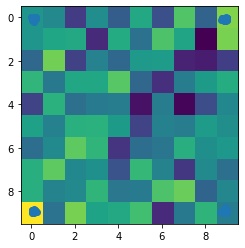

In [435]:
plt.imshow(all_data)
xys = [h[0] for h in history]
x = [el[0]%(bound)*(samples-1)/(bound) for el in xys]
y = [el[1]%(bound)*(samples-1)/(bound) for el in xys]
plt.scatter(x, y)

In [408]:
[h[0] for h in history]

[array([-0.55883229, -0.38982509]),
 array([-0.28129507, -0.41448123]),
 array([ 0.57971176, -0.13021802]),
 array([-0.28874004,  0.63590702]),
 array([ 0.93760597, -0.15050717]),
 array([-0.56480534,  0.06384132]),
 array([0.29432139, 0.09450011]),
 array([-0.09624799, -0.01470345]),
 array([-0.44239064, -0.25123299]),
 array([ 0.598015  , -0.27779765]),
 array([ 0.63793307, -0.08223258]),
 array([-0.45496573,  0.16456987]),
 array([ 0.3065969 , -0.26035258]),
 array([6.96810431e-01, 3.50915575e-04]),
 array([-0.22424069,  0.1239919 ]),
 array([0.18808171, 0.42082947]),
 array([-0.05057082, -0.50630317]),
 array([ 0.35198142, -0.60842285]),
 array([ 0.3591428, -0.1866496]),
 array([ 0.10051575, -0.18941189]),
 array([ 0.15916638, -0.03276358]),
 array([-0.06764785,  0.19838911]),
 array([-0.36461641, -0.28419274]),
 array([ 0.3249799 , -0.18082088]),
 array([ 0.32022529, -0.47441131]),
 array([-0.08972368, -0.36321185]),
 array([0.25245239, 0.62023633]),
 array([-0.15368648, -0.724092

In [409]:
# It's currently reporting the average fitness, which of course it might want to use when it's estimating the energy
# But at the end it should report the maximum value. Here the mean is 10.1, which suggests that a better bitstring was 
# sampled.

# Compute Maxcut of Graphs

In [473]:
from tqdm import tqdm
annealing_attempts = []
shots_per_point = 10
func, history2 = objective(graph)
np.random.seed(1)
initial_gamma_beta = [np.random.rand() * max_param for max_param in (max_gamma, max_beta)]
result = dual_annealing(
    lambda x: -1*func(x),
    bounds=[(-max_gamma*10, max_gamma*10),
            (-max_beta*10, 10*max_beta)],
    x0=np.array(initial_gamma_beta),
    # One annealing attempt.
    maxiter=100,
    maxfun=one_hour*reprate,
    seed=1,
    sigma=100)
result.fun = -result.fun
(result.x, result.fun)        

(array([-48.99019835,  30.41474091]), 475.2652096638651)

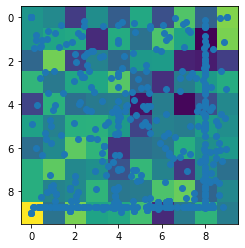

In [474]:
plt.imshow(all_data)
xys = [h[0] for h in history2]
x = [el[0]%(bound)*(samples-1)/(bound) for el in xys]
y = [el[1]%(bound)*(samples-1)/(bound) for el in xys]
plt.scatter(x, y)

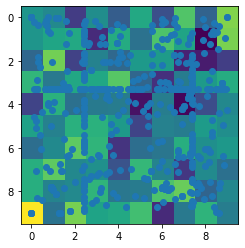

In [448]:
plt.imshow(all_data)
xys = [h[0] for h in history2]
x = [el[0]%(bound)*(samples-1)/(bound) for el in xys]
y = [el[1]%(bound)*(samples-1)/(bound) for el in xys]
plt.scatter(x, y)

In [350]:
shots_per_points = [1, 10, 100, 1000]
maxiters = [1, 10, 100, 1000]
initial_temp = [1, 10, 100, 1000]
restart_temp_ratio = [1E-10, 1E-9, 1E-8, 1E-7]

# Sweep Parameters

In [28]:
#shots_per_points = [1, 10, 100, 1000]
# It's currently returning the actual energy
maxiters = [1, 10, 100, 1000]
initial_temps = [1, 10, 100, 1000]
restart_temp_ratios = [1E-10, 1E-9, 1E-8, 1E-7]
data = []
for i, maxiter in  enumerate(maxiters):
    for initial_temp in initial_temps:
        for restart_temp_ratio in restart_temp_ratios:
            func, history2 = objective(graph)
            initial_gamma_beta = [np.random.rand() * max_param for max_param in (max_gamma, max_beta)]
            result = dual_annealing(
                lambda x: -1*func(x),
                bounds=[(0, max_gamma),
                        (0, max_beta)],
                x0=np.array(initial_gamma_beta),
                # One annealing attempt.
                maxiter=maxiter,
                initial_temp=initial_temp,
                maxfun=one_hour*reprate,
                restart_temp_ratio=restart_temp_ratio,
                no_local_search=True)
            result.fun = -result.fun
            data.append(((result.x, result.fun), history2))     
    print(f"Outer loop {i} done.")

Outer loop 0 done.
Outer loop 1 done.
Outer loop 2 done.
Outer loop 3 done.


In [29]:
import pickle as pkl

In [34]:
with open('data.pkl', 'wb') as file_:
    pkl.dump(data, file_)

In [42]:
m = 0
mi = 0
for i, _ in enumerate(data):
    if _[0][0][1] > m:
        m = max(m, _[0][0][1])
        mi = i

In [46]:
len(data)

64

In [41]:
terms

{(0, 6): 0.7004371218578347,
 (1, 8): 0.8441866428504345,
 (2, 8): 0.6765143359376254,
 (2, 10): 0.7278580572480748,
 (3, 4): 0.9514579574463393,
 (4, 5): 0.012703197034767633,
 (4, 9): 0.41358769878652346,
 (4, 14): 0.04881279380000003,
 (5, 13): 0.09992856132121142,
 (6, 10): 0.5080663057670065,
 (7, 9): 0.20024753933447748,
 (8, 9): 0.744154168814097,
 (11, 14): 0.19289200304058374,
 (12, 13): 0.7008447521659813,
 (13, 14): 0.293228105869234}